In [99]:
import numpy as np
import pandas as pd
from torch.utils import data
import os
import io
from sklearn.preprocessing import LabelEncoder
import cv2

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [157]:
class MuraDataset(data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, columns=[3, 4]):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            columns (int array, optional): an array of length 2. first element
                is the column that specifies path in the csv and second is
                the result
        """
        self.process_csv(csv_file, columns)
        self.root_dir = root_dir
        self.transform = transform
        
    def process_csv(self, file, columns):
        # read and update
        df = pd.read_csv(file)
        df = df.iloc[:, columns]
        df.columns = ['path', 'label']
        
        # encode labels
        le = LabelEncoder()
        df.label = le.fit_transform(df.label)
        
        # save
        self.le = le
        self.mura_frame = df

    def __len__(self):
        return len(self.mura_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.mura_frame.iloc[idx, 0])
        img = cv2.imread(img_name, 0)
        img = cv2.adaptiveThreshold(img, 255, 
                                    cv2.ADAPTIVE_THRESH_MEAN_C, 
                                    cv2.THRESH_BINARY, 11, 2)  
        img = Image.fromarray(img)
        img = self.transform(img)
        
        label = self.mura_frame.iloc[idx, 1]
        label = torch.from_numpy(label.reshape(1, 1))
        return {'image': img, 'label': label}

In [91]:
imgnet_transforms = transforms.Compose([
    transforms.Resize((227,227)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.456], std= [0.225])
])

In [162]:
md = MuraDataset(csv_file='../../data/processed/train_all.csv',
                 root_dir='../../data/', transform=imgnet_transforms)

In [163]:
md[0]['label']

tensor([[5]])

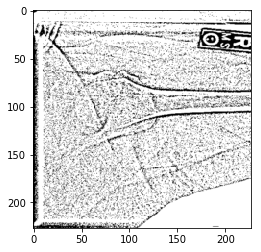

In [164]:
plt.imshow(md[0]['image'][0], cmap='gray')